# COVID 19 classification

In [22]:
 import os
 import torch
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 #os.environ['CUDA_VISIBLE_DEVICES']='1'
 torch.cuda.set_device('cuda:1')

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [24]:
from fastai.vision.all import *
from fastai.data.transforms import *
from fastai.data.core import *
from fastai.vision import data
from fastai.metrics import error_rate
import fastai; fastai.__version__
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import fastai; fastai.__version__
from sklearn.metrics import accuracy_score

In [25]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [38]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [39]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from dataset (including covids!) 

In [40]:
dfTrain = pd.read_csv(path+'train_split_v3.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train/processed/' + dfTrain[0].astype(str)
dfTrain.head()

idx_pa = dfTrain[1] == "COVID-19"  # Get COVID to augment.
dfTrain_covid =  dfTrain[idx_pa]
print(len (dfTrain_covid))
#augment de training covid data 2^3
for i in range(3):
    dfTrain_covid = dfTrain_covid.append(dfTrain_covid)
print('Org train '+str(len (dfTrain)))
dfTrain = dfTrain.append(dfTrain_covid, ignore_index=True)
print('Augmented train '+str(len (dfTrain)))


# adding padchest
dfTrain_padchest = pd.read_csv(path+'padchest/train_split_np.csv', header=None)
dfTrain_padchest['valid'] = 0
dfTrain_padchest[0] = 'padchest/trainNP/processed/' + dfTrain_padchest[0].astype(str)
dfTrain = dfTrain.append(dfTrain_padchest,ignore_index=True)

print('Final train '+str(len (dfTrain)))

271
Org train 13687
Augmented train 15855
Final train 24290


# Load Test


In [41]:
# Data from trueta, Tic Salut, Udiat
dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
dfTest2.head()
dfTest = dfTest.append(dfTest2,ignore_index=True)

# padchest to include normals and pneumonia (not used for training/validation/testing)
dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
dfTest3.head()
dfTest = dfTest.append(dfTest3,ignore_index=True)

#salutms (120 cases)
dfTest4 = pd.read_csv(path+'salutms/salutms_detect.csv',header=None)
dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)
dfTest4.head()
dfTest = dfTest.append(dfTest4,ignore_index=True)

test_dl=learn.dls.test_dl(dfTest, with_label=True)

### not done in v3 Load COVID for training from covid_vicorob

In [42]:
#dfTrainCovid = pd.read_csv(path+'covid_vicorob/covid_vicorob.csv', header=None)
#dfTrainCovid['valid'] = 0
#dfTrainCovid[0] = 'covid_vicorob/' + dfTrainCovid[0].astype(str)
#dfTrainCovid.head()
#print(len (dfTrainCovid))
#augment de training covid data 2^3
#for i in range(2):
#    dfTrainCovid = dfTrainCovid.append(dfTrainCovid)
#dfTrain = dfTrain.append(dfTrainCovid)
#print(len (dfTrain))


### Validation data from Seram & Normals

In [43]:
dfTest = pd.read_csv(path+'test_split_v3.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test/processed/' + dfTest[0].astype(str)
dfTest.head()

,0,1,valid
0,test/processed/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg,pneumonia,1
1,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg,pneumonia,1
2,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg,pneumonia,1
3,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg,pneumonia,1
4,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg,pneumonia,1


In [44]:
# dfTestCovid = pd.read_csv(path+'seram/covid_seram.csv',header=None)
# dfTestCovid['valid'] = 1
# dfTestCovid[0] = 'seram/' + dfTestCovid[0].astype(str)
# dfTestCovid.head()
# dfTest= dfTest.append(dfTestCovid)

In [45]:
df = dfTrain.append(dfTest, ignore_index=True)
df.head()

,0,1,valid
0,train/processed/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg,pneumonia,0
1,train/processed/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg,pneumonia,0
2,train/processed/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg,pneumonia,0
3,train/processed/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg,pneumonia,0
4,train/processed/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg,pneumonia,0


In [46]:
#np.random.seed(42)

tfms = []
dsets = ImageDataLoaders.from_df(df=df,path=path,  convert_mode='L', valid_col='valid', batch_tfms =tfms,
                              bs = bs, item_tfms = Resize(size = size_1, method ='squish'))

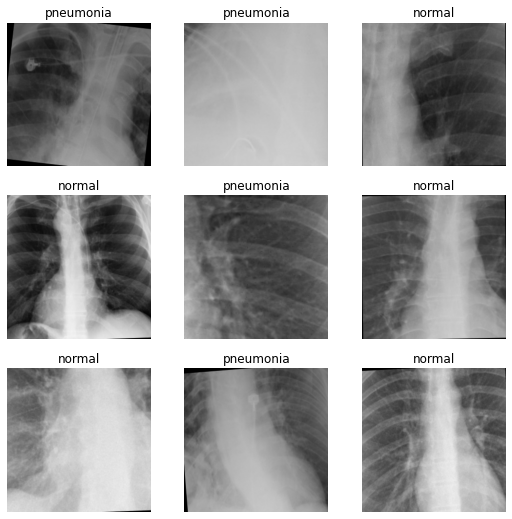

In [47]:
np.random.seed(42)

def splitter(df):
    train = df.index[df['valid']==0].tolist()
    valid = df.index[df['valid']==1].tolist()
    return train,valid

def get_image(r): return path+r[0]
def get_label(r): return r[1]
tfms = aug_transforms(pad_mode='zeros', do_flip=True,max_rotate=10,flip_vert=False, max_lighting=0.2, max_zoom=1.1, max_warp=0.)
dblock= DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 splitter=splitter,
                 get_x=get_image,
                 get_y=get_label,
                 item_tfms = RandomResizedCrop(300),
                 batch_tfms =[*tfms,Normalize.from_stats(*imagenet_stats)] )
dsets = dblock.dataloaders(df,bs=bs)
dsets.show_batch()
ds=dblock.datasets(df)

In [48]:
len([i for i in range(len(df[1])) if df[1][i]=="COVID-19" and df['valid'][i]==0])

2439

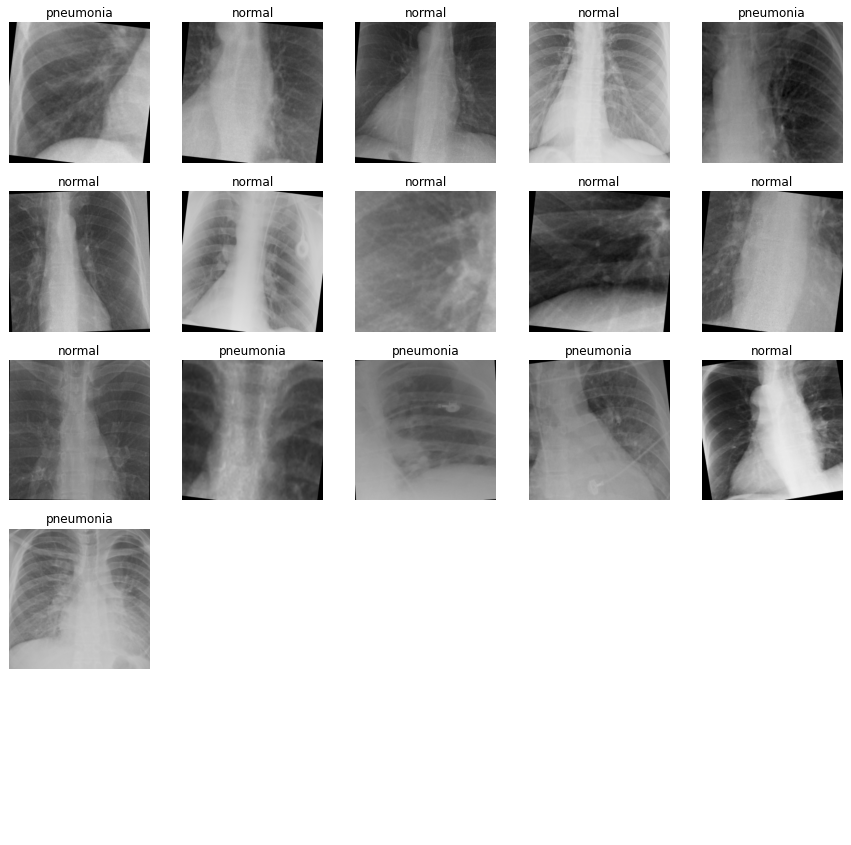

In [49]:
dsets.show_batch(nrows=5,ncols=5,figsize=(15,15),max_n=25)

In [50]:
len(dsets.train_ds)

24290

In [51]:
dsets.valid_ds


(#1579) [(PILImageBW mode=L size=1604x1275, TensorCategory(2)),(PILImageBW mode=L size=1274x1068, TensorCategory(2)),(PILImageBW mode=L size=1164x1121, TensorCategory(2)),(PILImageBW mode=L size=1184x1075, TensorCategory(2)),(PILImageBW mode=L size=1202x1030, TensorCategory(2)),(PILImageBW mode=L size=866x716, TensorCategory(0)),(PILImageBW mode=L size=872x758, TensorCategory(0)),(PILImageBW mode=L size=873x726, TensorCategory(0)),(PILImageBW mode=L size=906x723, TensorCategory(0)),(PILImageBW mode=L size=2504x2205, TensorCategory(0))...]

## learner

In [52]:
'''class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     
'''

'class fbeta_binary(Callback):\n    "Computes the f_beta between preds and targets for binary text classification"\n\n    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      \n        self.beta2=beta2**2\n        self.eps = eps\n        self.sigmoid = sigmoid\n    \n    def on_epoch_begin(self, **kwargs):\n        self.TP = 0\n        self.total_y_pred = 0   \n        self.total_y_true = 0\n    \n    def on_batch_end(self, last_output, last_target, **kwargs):\n        y_pred = last_output\n        y_pred = y_pred.softmax(dim = 1)        \n        y_pred = y_pred.argmax(dim=1)\n        y_true = last_target.float()\n        \n        self.TP += ((y_pred==1) * (y_true==1)).float().sum()\n        self.total_y_pred += (y_pred==1).float().sum()\n        self.total_y_true += (y_true==1).float().sum()\n    \n    def on_epoch_end(self, **kwargs):\n        prec = self.TP/(self.total_y_pred+self.eps)\n        rec = self.TP/(self.total_y_true+self.eps)\n        res = (prec*rec)/(prec*self

# Model Resnet 101

In [53]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = models.resnet101
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(dsets, arch, metrics=[accuracy, Precision(average='weighted'), error_rate])


In [54]:
lr=learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 1; 10.76 GiB total capacity; 3.44 GiB already allocated; 3.38 MiB free; 3.53 GiB reserved in total by PyTorch)

In [ ]:
learn.fit_one_cycle(10, slice(lr[0]))

In [ ]:
pred_probas, _, pred_classes = learn.get_preds(dl=test_dl, with_decoded=True)
real=np.where(np.array(dfTest[:][1])=='COVID-19', 0, np.array(dfTest[:][1]))
real=np.where(real=='normal', 1, real)
real=np.where(real=='pneumonia', 2, real)
pn=(real==pred_classes.numpy())
np_result=pred_classes.numpy()

In [ ]:
err_rate= 1-accuracy_score(real.tolist(),np.int16(pred_classes.numpy()).tolist())
err_rate

In [ ]:
cross_matrix_101_res=np.array([[0,0,0],[0,0,0],[0,0,0]])
for i in range(3):
    for j in range(3):
        cross_matrix[i, j]=sum([1 if (real[p]==i and np_result[p]==j) else 0 for p in range(len(np_result))])
        
cross_matrix_101_res

# Model Resnet50

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

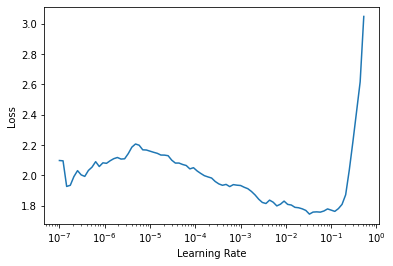

In [80]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = models.resnet50
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(dsets, arch, metrics=[accuracy, Precision(average='weighted'), error_rate])

learn.lr_find()

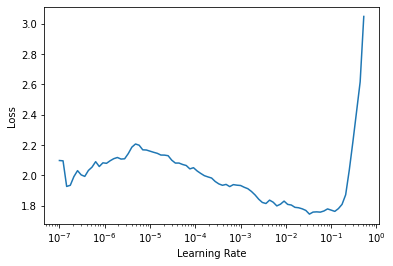

In [81]:
learn.recorder.plot_lr_find()

In [84]:
lr = 0.0033113110810518267

In [85]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.679770,0.351014,0.865104,0.861290,0.134896,03:07
1,0.528173,0.341018,0.880304,0.876401,0.119696,02:58
2,0.514369,0.312956,0.888537,0.891539,0.111463,02:58
3,0.461302,0.254405,0.910070,0.909524,0.089930,02:58
4,0.386984,0.260016,0.908170,0.908637,0.091830,02:58
5,0.357590,0.238066,0.922736,0.922109,0.077264,02:59
6,0.365769,0.227373,0.924003,0.923845,0.075997,02:58
7,0.341127,0.227624,0.927802,0.927682,0.072198,02:59
8,0.327430,0.223640,0.925902,0.925257,0.074098,02:59
9,0.323780,0.227119,0.922736,0.922650,0.077264,02:58


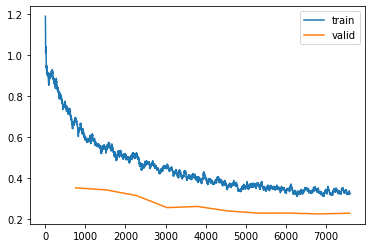

In [86]:
learn.recorder.plot_loss()

In [87]:
learn.save('stage-1-'+str(size_1)+'-dn50')

Path('models/stage-1-256-dn50.pth')

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dsets.valid_ds)==len(losses)==len(idxs)

True

In [89]:
dsets.vocab, dsets.c, len(dsets.train_ds), len(dsets.valid_ds)

(['COVID-19', 'normal', 'pneumonia'], 3, 24290, 1579)

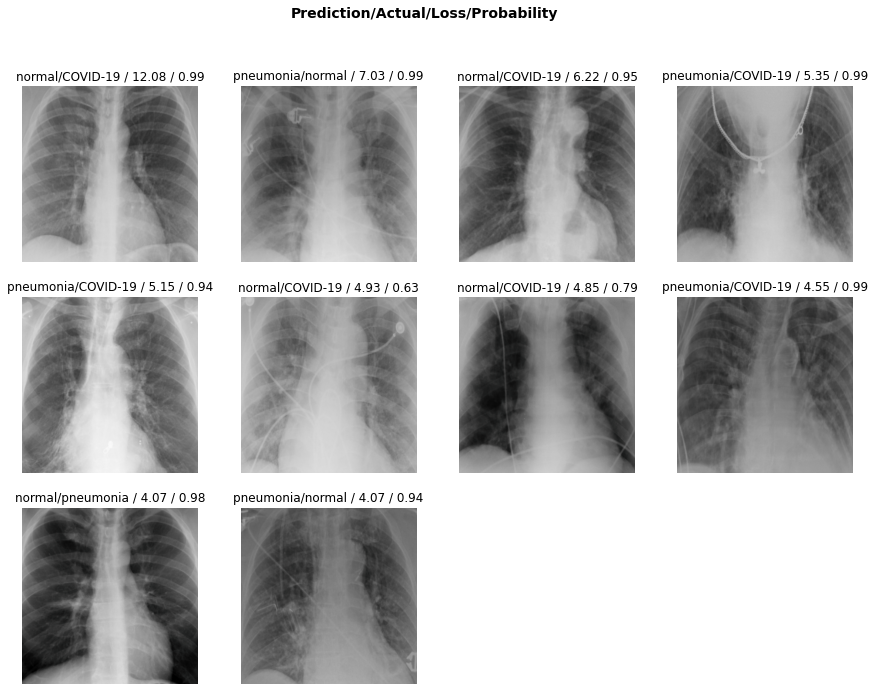

In [90]:
interp.plot_top_losses(10, figsize=(15,11))

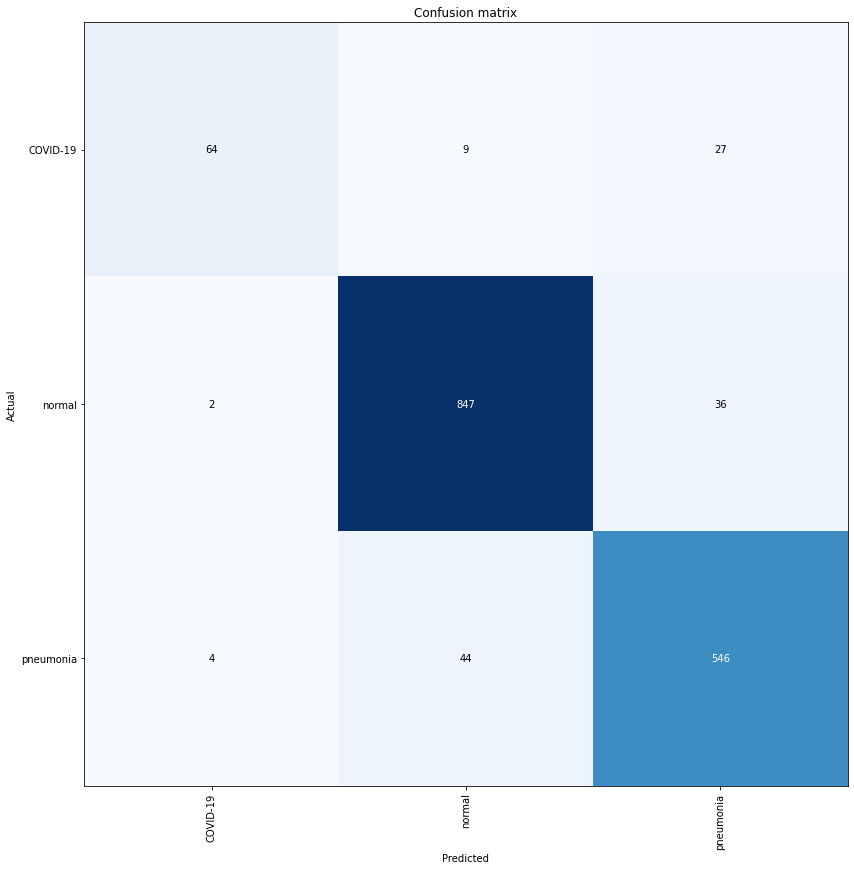

In [91]:
interp.plot_confusion_matrix(figsize=(12,12))

In [99]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 44),
 ('normal', 'pneumonia', 36),
 ('COVID-19', 'pneumonia', 27),
 ('COVID-19', 'normal', 9),
 ('pneumonia', 'COVID-19', 4),
 ('normal', 'COVID-19', 2)]

In [100]:
learn.unfreeze()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.3182567499825382e-06)

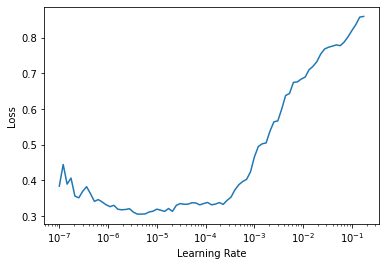

In [101]:
learn.lr_find()

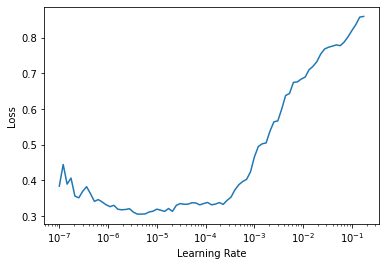

In [102]:
learn.recorder.plot_lr_find()

In [103]:
learn.fit_one_cycle(10,slice(2.0892961401841602e-06, lr/2))

epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.326829,0.230499,0.924003,0.923527,0.075997,03:54
1,0.371390,0.269651,0.904370,0.907663,0.095630,03:57
2,0.339480,0.217557,0.929069,0.929119,0.070931,03:54
3,0.306684,0.210832,0.918303,0.918595,0.081697,03:55
4,0.290052,0.212521,0.922103,0.922636,0.077897,03:56
5,0.289365,0.167329,0.932869,0.934177,0.067131,03:55
6,0.263921,0.219911,0.932869,0.934510,0.067131,03:55
7,0.230735,0.164601,0.937935,0.938320,0.062065,03:55
8,0.215533,0.186227,0.935402,0.936714,0.064598,03:56
9,0.203143,0.193809,0.935402,0.937067,0.064598,03:56


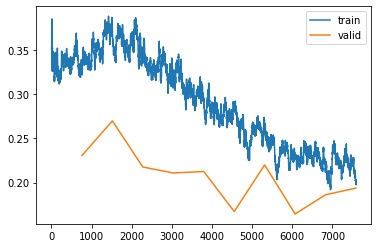

In [104]:
learn.recorder.plot_loss()

In [105]:
learn.save('stage-2-'+str(size_1)+'256-rn50')


Path('models/stage-2-256256-rn50.pth')

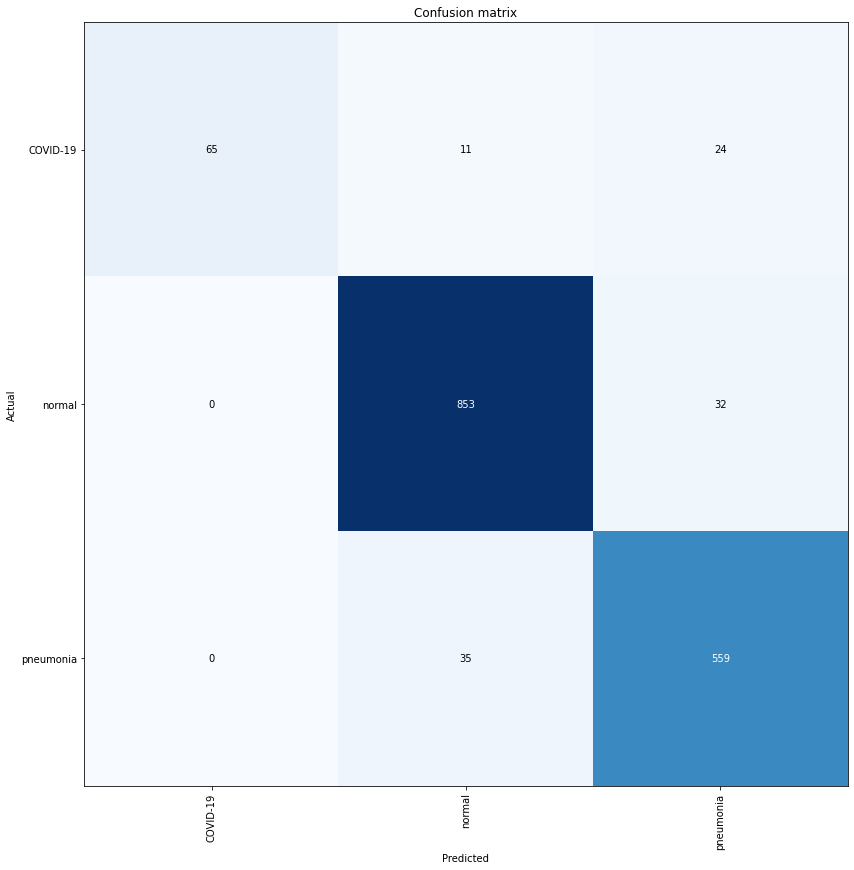

In [106]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dsets.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12))

### increasing image size

In [107]:
dblock= DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 splitter=splitter,
                 get_x=get_image,
                 get_y=get_label,
                 item_tfms = RandomResizedCrop(512),
                 batch_tfms =[*tfms,Normalize.from_stats(*imagenet_stats)] )
dsets = dblock.dataloaders(df,bs=bs)

learn.data = dsets
dsets.train_ds[0][0].shape

(1255, 1621)

In [108]:
learn.freeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=4.786300905834651e-06)

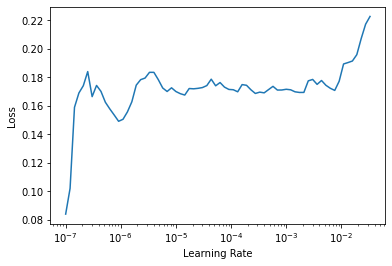

In [109]:
learn.lr_find()

In [111]:
lr=9.12010818865383e-08

In [112]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.236503,0.179472,0.936669,0.937849,0.063331,03:15
1,0.211443,0.192530,0.933502,0.935669,0.066498,03:09
2,0.228229,0.190281,0.936035,0.937563,0.063965,03:12
3,0.236220,0.201597,0.931602,0.934263,0.068398,03:11
4,0.225509,0.191244,0.933502,0.935429,0.066498,03:13
5,0.213318,0.202648,0.932236,0.934492,0.067764,03:11
6,0.226758,0.191385,0.932236,0.934310,0.067764,03:14
7,0.219088,0.178508,0.939835,0.941078,0.060165,03:12
8,0.224082,0.190165,0.932869,0.934882,0.067131,03:11
9,0.225571,0.177285,0.936669,0.938442,0.063331,03:11


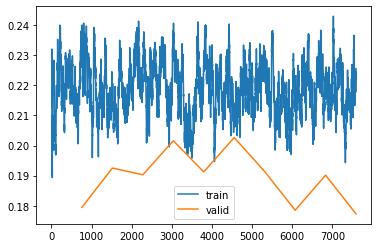

In [113]:
learn.recorder.plot_loss()

In [114]:
learn.save('stage-1-'+str(size_2)+'-rn50')

Path('models/stage-1-512-rn50.pth')

In [115]:
learn.unfreeze()

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775847473997e-07)

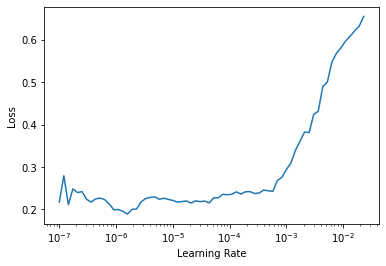

In [116]:
learn.lr_find()

In [117]:
learn.fit_one_cycle(5, slice(1.58489319801447e-07, lr/5))

epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.218118,0.184880,0.934136,0.936023,0.065864,03:57
1,0.216271,0.177339,0.936669,0.937730,0.063331,03:56
2,0.215548,0.187163,0.933502,0.935279,0.066498,03:58
3,0.231634,0.183037,0.934769,0.936657,0.065231,03:57
4,0.205169,0.208122,0.930969,0.933802,0.069031,03:56


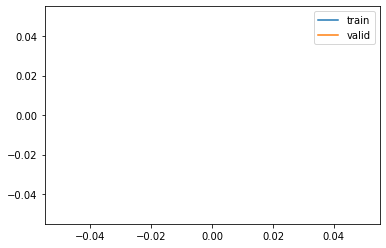

In [121]:
learn.recorder.plot_loss()

In [122]:
learn.save('stage-2-'+str(size_2)+'-rn50')


Path('models/stage-2-512-rn50.pth')

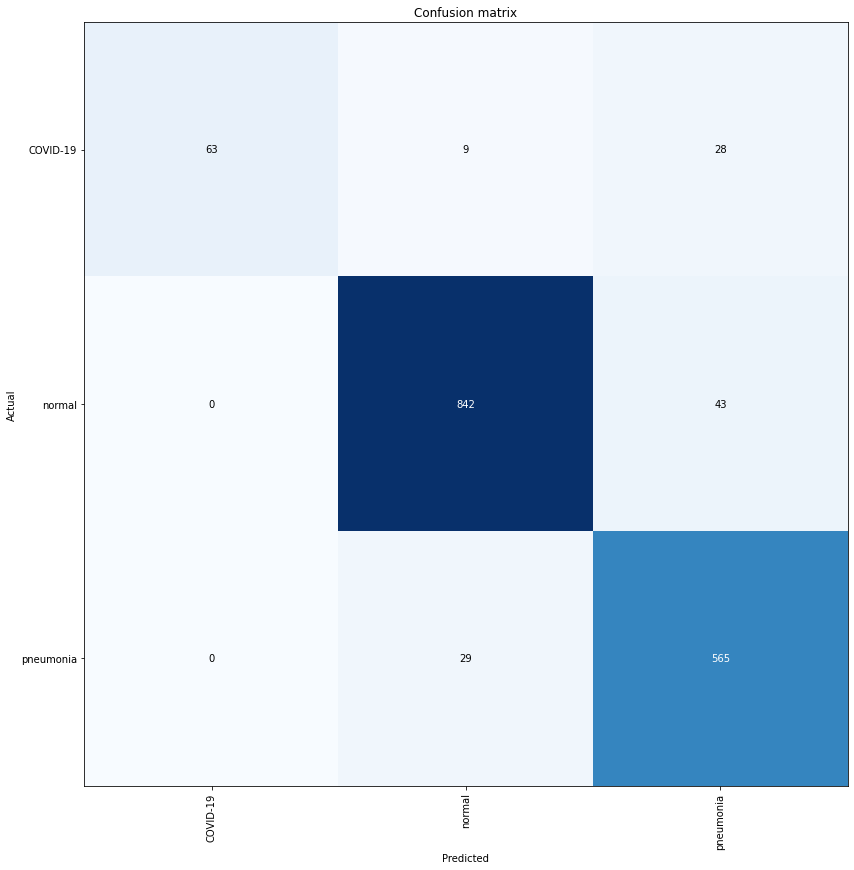

In [123]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dsets.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12))

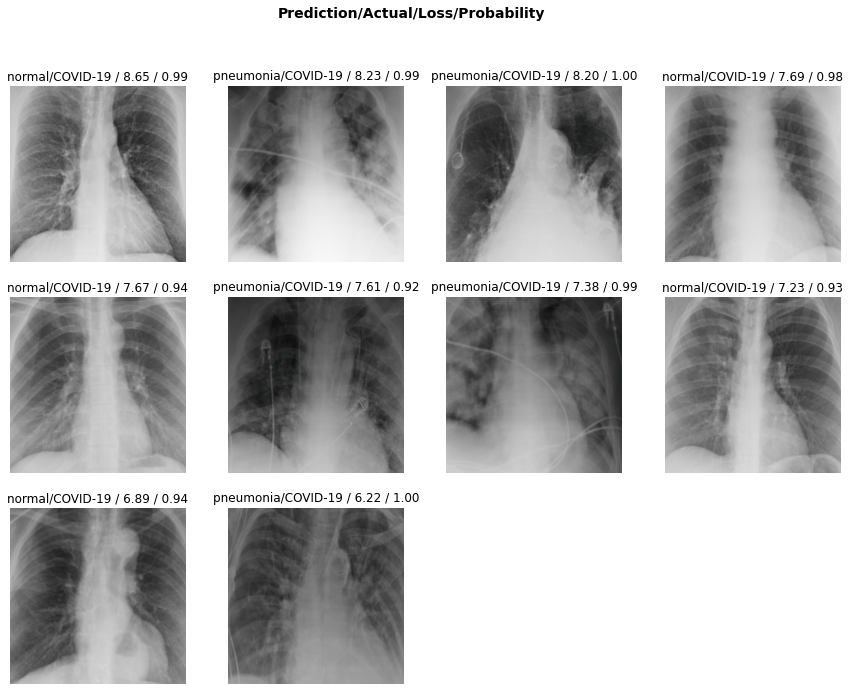

In [124]:
interp.plot_top_losses(10, figsize=(15,11), largest=True)

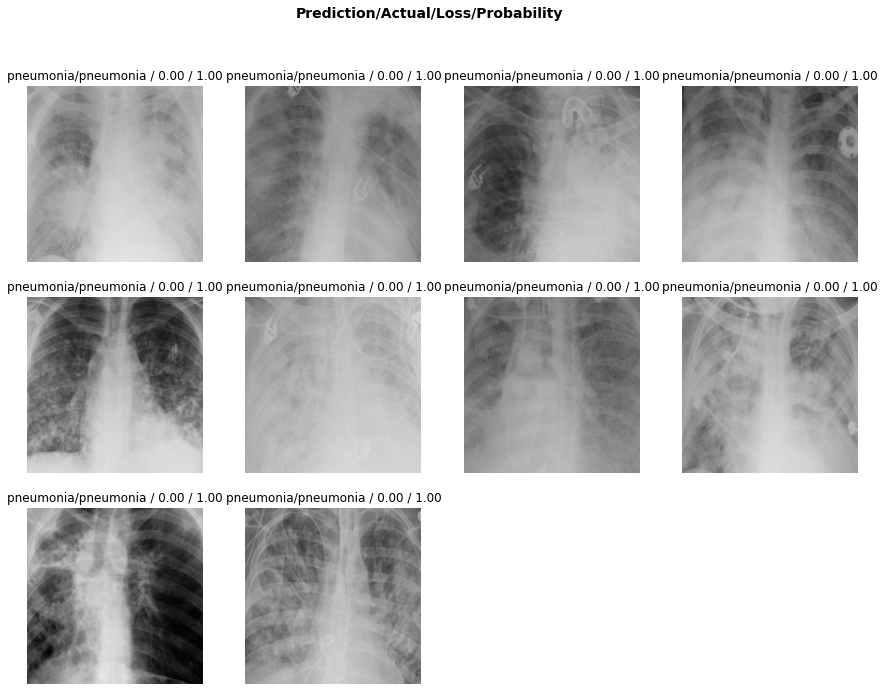

In [125]:
interp.plot_top_losses(10, figsize=(15,11), largest=False)

In [126]:
learn.export('trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')

### Test on new data

In [23]:
learn = load_learner("/home/elloret/trainedAllData_resnet_ROI_"+str(size_2)+'_export.pkl')

In [24]:
test_dl=learn.dls.test_dl(dfTest, with_label=True)
dblock= DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_x=get_image,
                 get_y=get_label,
                 item_tfms = RandomResizedCrop(512),
                 batch_tfms =[Normalize.from_stats(*imagenet_stats)] )
test = dblock.dataloaders(df,bs=64)
ts=dblock.datasets(df)

In [25]:
learn.valid_dls = test.train
#interp = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp.top_loss()

#len(data.valid_ds)==len(losses)==len(idxs)
#interp.plot_confusion_matrix(figsize=(12,12))
learn.dls

In [26]:
pred_probas, _, pred_classes = learn.get_preds(dl=test_dl, with_decoded=True)

In [27]:
print(pred_classes.numpy())
print(np.array(dfTest[:][1]))
real=np.where(np.array(dfTest[:][1])=='COVID-19', 0, np.array(dfTest[:][1]))
real=np.where(real=='normal', 1, real)
real=np.where(real=='pneumonia', 2, real)
print(real)
print(len(real))
print(len(pred_classes.numpy()))

[2 2 0 ... 0 0 0]
['COVID-19' 'COVID-19' 'COVID-19' ... 'COVID-19' 'COVID-19' 'COVID-19']
[0 0 0 ... 0 0 0]
1337
1337


In [36]:
pn=(real==pred_classes.numpy())
np_result=pred_classes.numpy()
len(pn[pn==True])

1158

In [29]:
err_rate= 1-accuracy_score(real.tolist(),np.int16(pred_classes.numpy()).tolist())
err_rate

0.1338818249813014

In [47]:
cross_matrix=np.array([[0,0,0],[0,0,0],[0,0,0]])
cross_matrix[0, 0]=sum([1 if (np_result[i]==real[i] and np_result[i]==0) else 0 for i in range(len(np_result))])
cross_matrix[0, 1]=sum([1 if (real[i]==0 and np_result[i]==1) else 0 for i in range(len(np_result))])
cross_matrix[0, 2]=sum([1 if (real[i]==0 and np_result[i]==2) else 0 for i in range(len(np_result))])
cross_matrix[1, 0]=sum([1 if (real[i]==1 and np_result[i]==0) else 0 for i in range(len(np_result))])
cross_matrix[1, 1]=sum([1 if (real[i]==1 and np_result[i]==1) else 0 for i in range(len(np_result))])
cross_matrix[1, 2]=sum([1 if (real[i]==1 and np_result[i]==2) else 0 for i in range(len(np_result))])
cross_matrix[2, 0]=sum([1 if (real[i]==2 and np_result[i]==0) else 0 for i in range(len(np_result))])
cross_matrix[2, 1]=sum([1 if (real[i]==2 and np_result[i]==1) else 0 for i in range(len(np_result))])
cross_matrix[2, 2]=sum([1 if (real[i]==2 and np_result[i]==2) else 0 for i in range(len(np_result))])

In [48]:
cross_matrix

array([[237,  24,  32],
       [  2, 640,  60],
       [  0,  61, 281]])

In [49]:
cross_matrix[0,1]

24